In [1]:
# Step 1: Retrieve and format pathway data for the specified organisms from the KEGG database.
# 1.1. Retrieve pathways

import requests
import pandas as pd

def get_pathways(organism_code, include_id=False):
    """
    Retrieves KEGG pathway information for a given organism.
    """
    url = f"http://rest.kegg.jp/list/pathway/{organism_code}"
    response = requests.get(url)
    if response.status_code == 200:
        pathways = response.text.strip().split('\n')
        if include_id:
            return [(entry.split('\t')[0], entry.split('\t')[1]) for entry in pathways]
        else:
            return [entry.split('\t')[1].rsplit(' - ', 1)[0] for entry in pathways]
    else:
        print(f"Failed to retrieve data for {organism_code}")
        return []

def retrieve_all_pathways(organism_codes, include_id=False):
    """
    Retrieves KEGG pathway information for multiple organisms.
    """
    return {code: get_pathways(code, include_id) for code in organism_codes}

def create_dataframe(all_pathways, include_id=False):
    """
    Creates a DataFrame from the retrieved pathways.
    """
    max_length = max(len(pathways) for pathways in all_pathways.values())
    data = []
    for i in range(max_length):
        row = []
        for code in all_pathways.keys():
            if i < len(all_pathways[code]):
                if include_id:
                    row.extend(all_pathways[code][i])
                else:
                    row.append(all_pathways[code][i])
            else:
                if include_id:
                    row.extend(["", ""])
                else:
                    row.append("")
        data.append(row)
    
    if include_id:
        headers = []
        for code in all_pathways.keys():
            headers.extend([f"KEGG ID {code}", code])
    else:
        headers = list(all_pathways.keys())
    
    return pd.DataFrame(data, columns=headers)

def save_to_csv(df, filename):
    """
    Saves the DataFrame to a CSV file.
    """
    df.to_csv(filename, index=False)
    print(f"Combined KEGG pathway data saved to '{filename}'.")


# List of organism codes
organism_codes = ["hsa", "pae", "lsv"]

# Generate 'combined_in_column.csv'
all_pathways_with_id = retrieve_all_pathways(organism_codes, include_id=True)
df_with_id = create_dataframe(all_pathways_with_id, include_id=True)
save_to_csv(df_with_id, 'ASMetliP_raw_data.csv')

# Generate 'all_noID_dash_symbol.csv'
all_pathways_no_id = retrieve_all_pathways(organism_codes, include_id=False)
df_no_id = create_dataframe(all_pathways_no_id, include_id=False)
save_to_csv(df_no_id, 'ASMetliP_processed_data.csv')

Combined KEGG pathway data saved to 'ASMetliP_raw_data.csv'.
Combined KEGG pathway data saved to 'ASMetliP_processed_data.csv'.


In [2]:
# 1.2. Checkpoint 1 (To make sure the code 1.1. works properly)
# 1.2.1. Compare the total number of pathways in the raw data against the KEGG database (they should be the same)

In [3]:
# 1.2.2. Processing data doesn't change the pathway names
# Duplicate shouldn't exist after removing KEGG ID & characters after ("-") (Read published paper for more detail explanation)
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv('ASMetliP_processed_data.csv')

# Iterate over each column (organism) and print the size and unique values
for column in df.columns:
    non_empty_count = df[column].dropna().ne("").sum()
    unique_values_count = df[column].dropna().unique().size
    print(f"Initial size of '{column}' column: {non_empty_count}")
    print(f"Unique values in '{column}' column: {unique_values_count}")

Initial size of 'hsa' column: 362
Unique values in 'hsa' column: 362
Initial size of 'pae' column: 135
Unique values in 'pae' column: 135
Initial size of 'lsv' column: 152
Unique values in 'lsv' column: 152


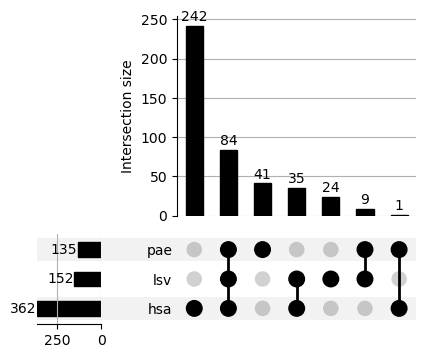

In [4]:
# Step 2: Identification overlapping & unique pathways using UpSet Plot
# 2.1. Plotting UpSet Plot
import pandas as pd
import matplotlib.pyplot as plt
from upsetplot import UpSet, from_contents
import warnings

# Ignore future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load the CSV file into a DataFrame
df = pd.read_csv('ASMetliP_processed_data.csv')

# Convert the DataFrame to a list of sets
list_of_sets = {column: set(df[column].dropna()) for column in df.columns}

# Convert the list of sets to a format compatible with UpSet
upset_data = from_contents(list_of_sets)

# Create the UpSet plot with intersections ordered by frequency and decreasing
upset_plot = UpSet(upset_data, show_counts='%d', sort_by='cardinality', 
                   sort_categories_by='cardinality')

# Plot the data
upset_plot.plot()

# Save the plot 300 dpi
plt.savefig('ASMetliP_upset_plot.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [5]:
# 2.2. Checkpoint 2 (Make sure UpSet plot works correctly) 
# compare the result from ASMetliP with three Venn diagram tools (InteractiVenn, jvenn, and VennDis)

In [6]:
# Step 3: Extracting the items based on intersection barplots
# 3.1. Extracting the items
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
from matplotlib import pyplot as plt
from upsetplot import UpSet, from_contents

def extract_shared_items(df, exclude_sets):
    sets_to_include = [col for col in df.columns if col not in exclude_sets]
    included_sets = {k: list_of_sets[k] for k in sets_to_include}
    excluded_sets = {k: list_of_sets[k] for k in exclude_sets}
    shared_items = set.intersection(*included_sets.values()) - set.union(*excluded_sets.values())
    return shared_items

def save_to_csv(data, filename):
    pd.DataFrame(list(data)).to_csv(filename, index=False, header=False)
    print(f"The data is saved to '{filename}'.")

# Load the CSV file into a DataFrame
df = pd.read_csv('ASMetliP_processed_data.csv')

# Convert the DataFrame to a list of sets
list_of_sets = {col: set(df[col].dropna()) for col in df.columns}

# Extract overlapping items between all organisms
all_organisms_shared_items = set.intersection(*list_of_sets.values())
save_to_csv(all_organisms_shared_items, 'ASMetliP_shared_items_all_organisms.csv')

# Extract unique items for each organism
unique_items = {org: items - set.union(*(list_of_sets[o] for o in list_of_sets if o != org)) for org, items in list_of_sets.items()}
unique_items_df = pd.DataFrame(dict([(k, pd.Series(list(v))) for k, v in unique_items.items()]))
unique_items_df.to_csv('ASMetliP_unique_items_each_organism.csv', index=False)
print(f"The unique items for each organism are saved to 'ASMetliP_unique_items_each_organism.csv'.")

# To retrieve other possible combinations based on script 2.1. 
# user can just need to modify the code of organisms like the following examples
# To activate the code in the line 42-43, 46-47, 50-51, & 54-56 remove "#".

# # Extract shared items for all organisms except hsa
# shared_items_except_hsa = extract_shared_items(df, ['hsa'])
# save_to_csv(shared_items_except_hsa, 'ASMetliP_shared_items_except_hsa.csv')

# # Extract shared items for all organisms except lsv
# shared_items_except_lsv = extract_shared_items(df, ['lsv'])
# save_to_csv(shared_items_except_lsv, 'ASMetliP_shared_items_except_lsv.csv')

# # Extract shared items for all organisms except pae
# shared_items_except_pae = extract_shared_items(df, ['pae'])
# save_to_csv(shared_items_except_pae, 'ASMetliP_shared_items_except_pae.csv')

# # OPTIONAL: Create and plot UpSet data
# upset_data = from_contents(list_of_sets)
# UpSet(upset_data, show_counts='%d', sort_by='cardinality', sort_categories_by='cardinality').plot()
# plt.show()

The data is saved to 'ASMetliP_shared_items_all_organisms.csv'.
The unique items for each organism are saved to 'ASMetliP_unique_items_each_organism.csv'.


In [7]:
# 3.2. Checkpoint 3 (Make sure the script 3.1 works properly) 
# compare the result from ASMetliP with the extracted items produced by the three Venn diagram tools (InteractiVenn, jvenn, and VennDis)

In [8]:
# Supplementary scrpit 1 (Searching KEGG ID using pathway names)
import pandas as pd

# Read the CSV file
df = pd.read_csv('ASMetliP_raw_data.csv')

# Slice the columns using [1::2] and [0::2]
sliced_df = df.iloc[:, 1::2].copy()
kept_df = df.iloc[:, 0::2].copy()

# Function to delete all characters after the last dash symbol
def delete_after_last_dash(value):
    if isinstance(value, str) and '-' in value:
        return value.rsplit('-', 1)[0]
    return value

# Apply the function to each column in the sliced DataFrame using .loc
for column in sliced_df.columns:
    sliced_df.loc[:, column] = sliced_df[column].apply(delete_after_last_dash)

# Concatenate the kept columns and modified columns
modified_df = pd.concat([kept_df, sliced_df], axis=1)

# Reorder the columns to match the original order
modified_df = modified_df[df.columns]

# Assign modified_df into df before searching specific KEGG ID for pathway names
df = modified_df

# Read the CSV file containing query items
query_items_df = pd.read_csv('ASMetliP_shared_items_all_organisms.csv', header=None)

# Convert the DataFrame to a single column by stacking and resetting the index
query_items_single_column = query_items_df.stack().reset_index(drop=True).to_frame(name='Query_Items')

# Extract the list of query items
query_items = query_items_single_column['Query_Items'].tolist()

# Select every other column starting from the second column (index 1)
selected_columns = df.iloc[:, 1::2]

# Search for exact matches of query items in the selected columns
result = selected_columns[selected_columns.apply(lambda row: row.astype(str).apply(lambda x: x.strip()).isin(query_items)).any(axis=1)]

# Get the indices of rows with matches
match_indices = result.index

# Create a DataFrame to store the results
final_results = []

# Iterate over the matched rows to find the previous column item
for idx in match_indices:
    row = df.iloc[idx, :]
    for col in range(1, len(row), 2):
        if str(row.iloc[col]).strip() in query_items:
            previous_item = row.iloc[col-1]
            final_results.append({'KEGG_ID': previous_item, 'Search_Item': row.iloc[col]})

# Convert the results to a DataFrame
final_results_df = pd.DataFrame(final_results)

# Print the search results
print("Final Results:")
print(final_results_df)

# Save the search results to a new CSV file without KEGG ID
final_results_df.to_csv('ASMetliP_searching_kegg_id.csv', index=False)

Final Results:
      KEGG_ID                       Search_Item
0    hsa01100               Metabolic pathways 
1    pae01100               Metabolic pathways 
2    lsv01100               Metabolic pathways 
3    hsa01200                Carbon metabolism 
4    hsa01210  2-Oxocarboxylic acid metabolism 
..        ...                               ...
247  lsv04148                    Efferocytosis 
248  lsv04981  Folate transport and metabolism 
249  hsa04146                       Peroxisome 
250  hsa04148                    Efferocytosis 
251  hsa04981  Folate transport and metabolism 

[252 rows x 2 columns]


In [9]:
# Supplementary scrpit 2 (format the output of Supplementary scrpit 2 from single column into multiple columns)
import pandas as pd

# Load the CSV file
df = pd.read_csv('ASMetliP_searching_kegg_id.csv')

# Identify unique items in the Search_Item column
unique_items = df['Search_Item'].unique()

# Create a new DataFrame to store the results
result_df = pd.DataFrame()

# Iterate over unique items and pair them with their corresponding Previous_Item
for item in unique_items:
    pairs = df[df['Search_Item'] == item]
    result_df = pd.concat([result_df, pairs.reset_index(drop=True)], axis=1)

# Save the result to a new file without using tab as separator
result_df.to_csv('ASMetliP_clustering_same_items_in_column.csv', index=False)

# Print the result
print(result_df)

    KEGG_ID          Search_Item   KEGG_ID         Search_Item   KEGG_ID  \
0  hsa01100  Metabolic pathways   hsa01200  Carbon metabolism   hsa01210   
1  pae01100  Metabolic pathways   lsv01200  Carbon metabolism   lsv01210   
2  lsv01100  Metabolic pathways   pae01200  Carbon metabolism   pae01210   

                        Search_Item   KEGG_ID             Search_Item  \
0  2-Oxocarboxylic acid metabolism   hsa01212  Fatty acid metabolism    
1  2-Oxocarboxylic acid metabolism   lsv01212  Fatty acid metabolism    
2  2-Oxocarboxylic acid metabolism   pae01212  Fatty acid metabolism    

    KEGG_ID                   Search_Item  ...   KEGG_ID  \
0  hsa01230  Biosynthesis of amino acids   ...  hsa03250   
1  lsv01230  Biosynthesis of amino acids   ...  pae03250   
2  pae01230  Biosynthesis of amino acids   ...  lsv03250   

                 Search_Item   KEGG_ID        Search_Item   KEGG_ID  \
0  Viral life cycle - HIV-1   pae02010  ABC transporters   pae04146   
1  Viral life cycle